In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.naive_bayes import GaussianNB, CategoricalNB, BernoulliNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from scipy.signal import savgol_filter
import matplotlib.ticker as plticker


In [17]:
# writer = pd.ExcelWriter("Ket qua phan loai khong dao ham.xlsx", engine='xlsxwriter')

In [18]:
data = pd.read_excel("../../data/Dataset_HPLC.xlsx", sheet_name="Vungtrong (140)")
data.head(5)

,No.,Name,Group,%CM,%CA,%CAL,600,602,604,606,...,3982,3984,3986,3988,3990,3992,3994,3996,3998,4000
0,1,21.1.8.YB-13,1,2.57,0.09,9.83,0.222,0.223,0.221,0.217,...,-0.006,-0.006,-0.006,-0.006,-0.006,-0.006,-0.006,-0.006,-0.006,-0.006
1,2,21.1.8.YB-24,1,0.69,0.04,3.75,0.263,0.261,0.257,0.257,...,-0.007,-0.007,-0.007,-0.007,-0.006,-0.007,-0.007,-0.007,-0.007,-0.007
2,3,21.1.8.YB-38,1,0.43,0.05,5.53,0.252,0.253,0.253,0.252,...,-0.006,-0.007,-0.007,-0.007,-0.006,-0.007,-0.007,-0.007,-0.007,-0.007
3,4,21.1.8.YB-40,1,2.04,0.06,5.21,0.259,0.258,0.259,0.259,...,-0.008,-0.009,-0.009,-0.009,-0.008,-0.008,-0.008,-0.009,-0.009,-0.009
4,5,21.1.8.YB-41,1,0.13,0.09,4.60,0.206,0.203,0.200,0.198,...,0.000,-0.001,0.000,0.001,0.001,0.000,0.000,-0.001,-0.001,-0.001


In [19]:
y = data["Group"]
# le = LabelEncoder()
# y = le.fit_transform(y)
X = data.iloc[:, 6:]
X.columns = X.columns.astype(str)
cols = X.columns
# print(np.unique(y))
# print(le.inverse_transform(np.unique(y)))

In [20]:
X = savgol_filter(X, window_length=25, polyorder=5, deriv=2)

In [21]:
X = pd.DataFrame(X, columns=cols)

C:\Users\84866\AppData\Local\Temp\ipykernel_4572\495723894.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')


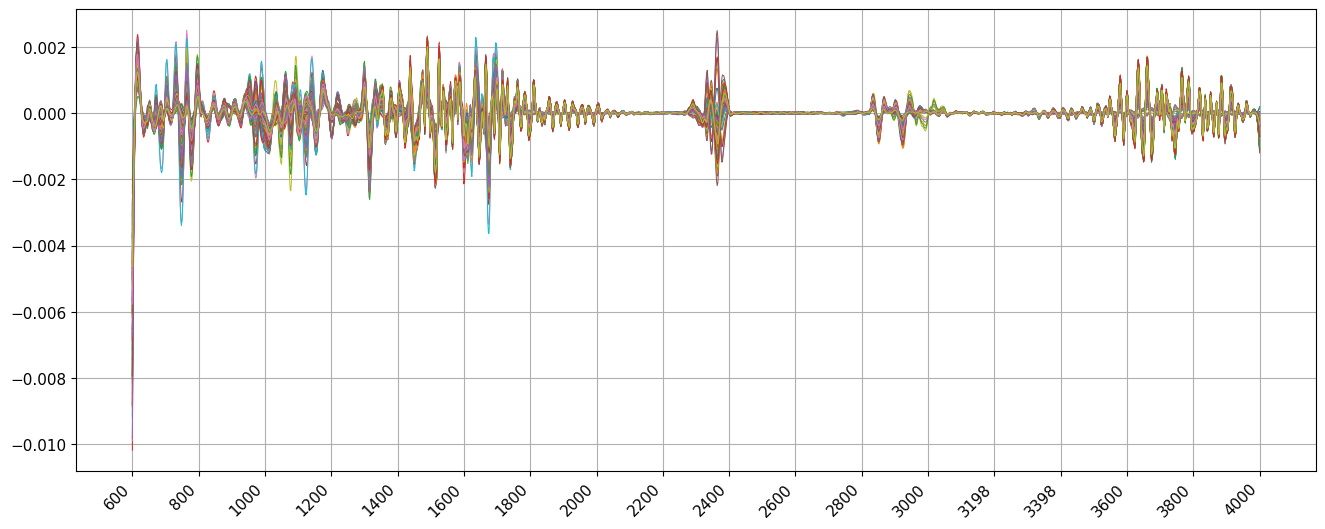

In [22]:
fig, ax = plt.subplots(figsize = (16, 6))
ax.plot(X.T, linewidth = 0.7)
loc = plticker.MultipleLocator(base=100.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
# ax.set_xticks(rotation = 90)
plt.grid()
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')
plt.show()

In [23]:
X = np.array(X)  # In case it's not already a NumPy array
y = np.array(y)

n_classes = len(np.unique(y))
# Define how many samples per class you want in the validation set
n_test_samples_per_class = int(len(X) * 0.25 / n_classes)  # Modify this based on your need

# Get unique class labels
classes = np.unique(y)
# Lists to hold train and test data
X_train_list, X_test_list = [], []
y_train_list, y_test_list = [], []

# For each class, split data to have equal test size
for cls in classes:
    # Get indices for this class
    class_indices = np.where(y == cls)[0]
    
    # Split the data for this class
    X_class, X_class_test, y_class, y_class_test = train_test_split(
        X[class_indices], y[class_indices], test_size=n_test_samples_per_class, random_state=42
    )
    
    # Append the splits to the train/test lists
    X_train_list.append(X_class)
    X_test_list.append(X_class_test)
    y_train_list.append(y_class)
    y_test_list.append(y_class_test)

# Combine back into arrays
X_train = np.vstack(X_train_list)  # Combine all classes' training data
X_test = np.vstack(X_test_list)      # Combine all classes' test data
y_train = np.hstack(y_train_list)  # Combine all classes' training labels
y_test = np.hstack(y_test_list)      # Combine all classes' test labels

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_test.shape, y_test.shape)

Training set shape: (107, 1701) (107,)
Validation set shape: (32, 1701) (32,)


In [24]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.fit_transform(X_test)

In [25]:
onehot = OneHotEncoder(sparse_output=False)
y_train = onehot.fit_transform(y_train.reshape(-1,1))
y_test = onehot.fit_transform(y_test.reshape(-1,1))

In [26]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [27]:
import tensorflow as tf
import random

tf.random.set_seed(1)
random.seed(1)
np.random.seed(1)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(X_train.shape[1], 1)))
# model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
# model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=3))
# model.add(tf.keras.layers.Conv1D(filters=24, kernel_size=3))
# model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(16, activation='relu'))
# model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer="Adam", loss = 'CategoricalCrossentropy', metrics = ['accuracy'])
history=model.fit(X_train, y_train, batch_size=12, epochs=24, validation_data=(X_test, y_test))

Epoch 1/24
9/9 [==============================] - 3s 102ms/step - loss: 1.1117 - accuracy: 0.5888 - val_loss: 0.5919 - val_accuracy: 0.9688
Epoch 2/24
9/9 [==============================] - 0s 28ms/step - loss: 0.3693 - accuracy: 0.8785 - val_loss: 0.2912 - val_accuracy: 0.9688
Epoch 3/24
9/9 [==============================] - 0s 27ms/step - loss: 0.1397 - accuracy: 0.9439 - val_loss: 0.5066 - val_accuracy: 0.8750
Epoch 4/24
9/9 [==============================] - 0s 26ms/step - loss: 0.0833 - accuracy: 0.9813 - val_loss: 0.4008 - val_accuracy: 0.9688
Epoch 5/24
9/9 [==============================] - 0s 24ms/step - loss: 0.0784 - accuracy: 0.9813 - val_loss: 0.8842 - val_accuracy: 0.9062
Epoch 6/24
9/9 [==============================] - 0s 27ms/step - loss: 0.1218 - accuracy: 0.9907 - val_loss: 0.3165 - val_accuracy: 0.9688
Epoch 7/24
9/9 [==============================] - 0s 27ms/step - loss: 0.0594 - accuracy: 0.9907 - val_loss: 0.2222 - val_accuracy: 0.9688
Epoch 8/24
9/9 [==========

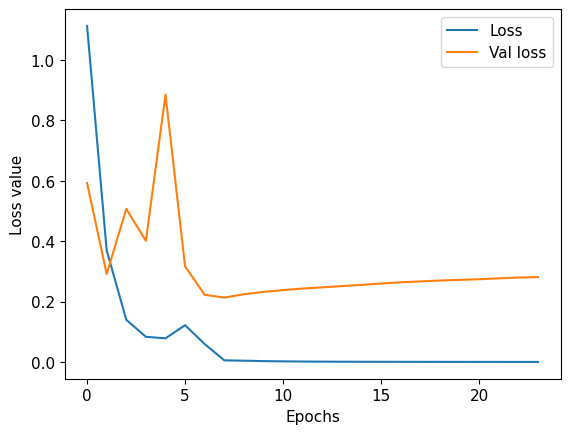

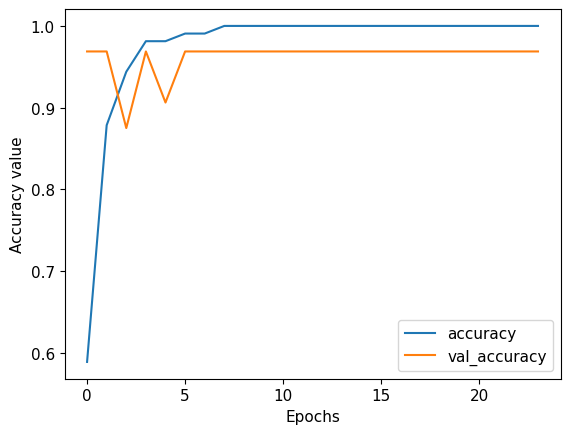

In [28]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy value')
plt.legend()
plt.show()

1/1 [==============================] - 0s 423ms/step
0.96875


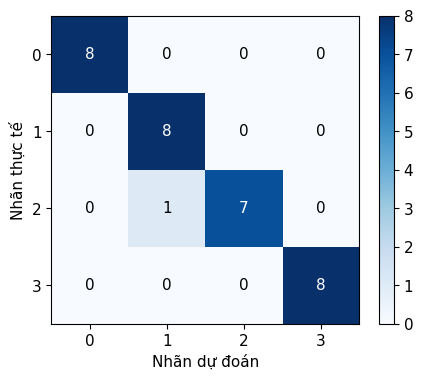

In [29]:
from mlxtend.plotting import plot_confusion_matrix
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_m = np.argmax(y_test, axis=1)
print(accuracy_score(y_test_m, y_pred))
# print(precision_score(y_test_m, y_pred))
# print(recall_score(y_test_m, y_pred))
# print(f1_score(y_test_m, y_pred))
cm = confusion_matrix(y_test_m, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm, colorbar=True, figsize=(5,4))
plt.rcParams.update({'font.size': 11})
plt.xlabel("Nhãn dự đoán")
plt.ylabel("Nhãn thực tế")
plt.show()

In [30]:
print(classification_report(y_test_m, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.89      1.00      0.94         8
           2       1.00      0.88      0.93         8
           3       1.00      1.00      1.00         8

    accuracy                           0.97        32
   macro avg       0.97      0.97      0.97        32
weighted avg       0.97      0.97      0.97        32

